In [1]:
import pandas as pd
import psycopg2
import numpy as np
import matplotlib.pyplot as plt

# Plot settings
%matplotlib inline
plt.style.use('ggplot')
fontsize = 40 # size for x and y ticks
plt.rcParams['legend.fontsize'] = fontsize
plt.rcParams.update({'font.size': fontsize})

con = psycopg2.connect(dbname='eicu', user='postgres', host='localhost', port=5432)



q2 = """select
    DISTINCT
  t.patientunitstayid as pid
  ,t.treatmentid as tid
  ,t.treatmentoffset as toffset
  ,%(phsid)s as phsid
from
	eicu_crd.treatment t
where t.treatmentstring like 'pulmonary|ventilation and oxygenation|prone position'
  and t.patientunitstayid in (select patientunitstayid from patient where patienthealthsystemstayid = %(phsid)s)
order by t.patientunitstayid"""

query =""" 
select 
	fi.pid,
    fi.lab_time,
    pa.res/fi.res as "PF ratio"
    ,%(phsid)s as phsid
from 
	(select
     	patientunitstayid as pid
     	,case
       when labresult is not NULL THEN labresult/100
       when labresult is NULL and nullif(labresulttext,'') is NOT NULL then replace(labresulttext,'%%','')::FLOAT/100
       else NULL
      end as res
     	,labresultoffset as lab_time
     from
     	eicu_crd.lab
     where 
     	patientunitstayid in (select patientunitstayid from patient
                            where patienthealthsystemstayid = %(phsid)s )
     	and labname = 'FiO2') as fi
     ,(select 
      	patientunitstayid as pid
      	,labresult as res
      	,labresultoffset as lab_time
      from
      	eicu_crd.lab
      where
      	patientunitstayid in (select patientunitstayid from patient
                            where patienthealthsystemstayid = %(phsid)s)
      	and labname = 'paO2') as pa
where pa.lab_time = fi.lab_time
and pa.pid = fi.pid
and fi.res is not NULL
order by pa.lab_time"""

q3 = """
    select distinct patientunitstayid from patient
    where patienthealthsystemstayid = %(phsid)s
                            """

In [125]:
param = {'phsid': 468289}
tr = pd.read_sql_query(query, con, params=param)
tr2 = pd.read_sql_query(q2, con, params=param)
df3 = tr.merge(tr2, how='left', on=['phsid']).copy()
# df3.drop_duplicates(keep='first',inplace=True)
# tr3 = pd.read_sql_query(q3, con, params=param)
# tr3
df3['closed'] = ((df3['toffset'] - df3['lab_time'])/60).astype(float)

df3[['phsid','lab_time','PF ratio','toffset','closed']].head(10)


,phsid,lab_time,PF ratio,toffset,closed
0,468289,-125,92.300000,6953,117.966667
1,468289,-125,92.300000,6965,118.166667
2,468289,-125,92.300000,7203,122.133333
3,468289,1330,162.600000,6953,93.716667
4,468289,1330,162.600000,6965,93.916667
5,468289,1330,162.600000,7203,97.883333
6,468289,3303,84.666667,6953,60.833333
7,468289,3303,84.666667,6965,61.033333
8,468289,3303,84.666667,7203,65.000000
9,468289,3610,60.800000,6953,55.716667


In [126]:
tr.sort_values('lab_time',inplace=True)
tr2.sort_values('toffset',inplace=True)



df2 = pd.merge_asof(tr2[['toffset']],tr[['lab_time','PF ratio']], right_on='lab_time', left_on='toffset', direction='backward',tolerance=24*60).copy()
df2.rename(columns={"PF ratio": "Before"},inplace=True) 
df2['time_before'] = ((df2['toffset'] - df2['lab_time'])/60).astype(float)
df2

,toffset,lab_time,Before,time_before
0,6953,6685,36.9,4.466667
1,6965,6685,36.9,4.666667
2,7203,7065,31.4,2.300000


In [127]:
df4 = pd.merge_asof(tr2[['toffset']],tr[['lab_time','PF ratio']], right_on=['lab_time'], left_on='toffset', direction='forward',tolerance=48*60).copy()
df4.rename(columns={"PF ratio": "After"},inplace=True) 
df4['time_after'] = ((df4['lab_time'] - df4['toffset'])/60).astype(float)
df4

,toffset,lab_time,After,time_after
0,6953,7065.0,31.4,1.866667
1,6965,7065.0,31.4,1.666667
2,7203,NaN,NaN,NaN


In [128]:
df7 = pd.merge(df2[['toffset','Before','time_before']],df4[['toffset','After','time_after']],on='toffset').copy()
df7 = df7[~(df7['After'].isnull()) & ~(df7['Before'].isnull())]
df7['pf delta'] = ((df7['After'] - df7['Before'])).astype(int)
df7

,toffset,Before,time_before,After,time_after,pf delta
0,6953,36.9,4.466667,31.4,1.866667,-5
1,6965,36.9,4.666667,31.4,1.666667,-5


In [129]:
df8 = df3[['PF ratio','lab_time','toffset']].drop_duplicates()

defulat_tol = 48
df8 = df8[np.abs(df8['lab_time']-df8['toffset'])<defulat_tol*60]

df8.reset_index(inplace=True,drop=True)


In [130]:
def trendline(data, order=1):
    coeffs = np.polyfit(data.index.values, list(data), order)
    slope = coeffs[-2]
    return float(slope)

def extract_trend(rel_dict):
    trend_dict = {}
    for key, value in rel_dict.items():
        if len(value['PF ratio']) <= 1:
            trend_dict[key] = {'trend': 'single','tol': defulat_tol}
        elif value['PF ratio'].is_monotonic_decreasing:
            trend_dict[key] = {'trend':'decreasing','tol': defulat_tol}
        elif value['PF ratio'].is_monotonic_increasing:
            trend_dict[key] = {'trend': 'increasing','tol': defulat_tol}       
        else:
#             for tol in [48,36,24,20,18,16,12,8]:
#                 temp = value[value['offset'] < tol*60]
#                 if len(temp) < 1:
#                     print(value)
#                     break;
#                 elif len(temp) == 1:
#                     trend_dict[key] = {'trend': 'single','tol': tol}
#                     break;
#                 elif temp['PF ratio'].is_monotonic_decreasing:
#                     trend_dict[key] = {'trend':'decreasing','tol': tol}
#                     break;
#                 elif temp['PF ratio'].is_monotonic_increasing:
#                     trend_dict[key] = {'trend': 'increasing','tol': tol}
#                     break;
            slope = trendline(value['PF ratio'])
            if slope > 0:
                trend_dict[key] = {'trend': 'increasing','tol': defulat_tol,'slope': slope}
            else:
                trend_dict[key] = {'trend': 'decreasing','tol': defulat_tol,'slope': slope}
#             else:
#                 trend_dict[key]= {'trend': 'not defnitive','tol':24}
    temp_df = pd.DataFrame(data=trend_dict)
    trend_df = temp_df.transpose()
#     trend_df.reset_index(inplace=True)
#     trend_df.rename(columns={"index": "toffset"},inplace=True) 
    return trend_df.copy()

In [131]:
before_tol = 24*60
df9 = df8[df8['lab_time'] < df8['toffset']].copy()
df9['offset'] = ((df9['toffset'] - df9['lab_time'])).astype(int)

df9 = df9[df9['offset'] < before_tol]

df9.reset_index(inplace=True,drop=True)
df9.sort_values(['toffset','lab_time'],inplace=True)

gb9 = df9.groupby('toffset')    
dict_before = {x:gb9.get_group(x) for x in gb9.groups}

df_before = extract_trend(dict_before)

df_before

# trendline(dict_before[121]['PF ratio'])
# df8.loc[(df8['lab_time'] < df8['toffset']) & np.abs(df8['toffset'] - df8['lab_time']) < before_tol]

,slope,tol,trend
6953,-1.08333,48,decreasing
6965,-1.08333,48,decreasing
7203,-1.71333,48,decreasing


In [132]:
df10 = df8[df8['lab_time']>df8['toffset']].copy()
df10['offset'] = ((df10['lab_time'] - df10['toffset'])).astype(int)
df10.sort_values(['toffset','lab_time'],inplace=True)

gb10 = df10.groupby('toffset')    
dict_after = {x:gb10.get_group(x) for x in gb10.groups}

df_after = extract_trend(dict_after)

df_after


,tol,trend
6953,48,single
6965,48,single


In [133]:

df_results = pd.merge(df_before,df_after,right_index=True,left_index=True,how='outer',suffixes=('_before','_after'))
df_results[(df_results['trend_before']!='single') & ~(df_results['trend_before'].isnull()) 
           & (df_results['trend_after']!='single') & ~(df_results['trend_after'].isnull()) ]


,slope,tol_before,trend_before,tol_after,trend_after


In [134]:
retult_dict = {}
for key in list(df_results.index):
    try:
#         value[value['offset'] < tol*60]
        before = dict_before[key]['PF ratio'].mean()
        after = dict_after[key]['PF ratio'].mean()
        if np.isnan(before) or np.isnan(after):
            delta = 'missing data'
        else:
            delta = after - before
        retult_dict[key] = {'result': delta}
    except KeyError:
        print("missing data for prone change: {}".format(key))
result = pd.DataFrame(data=retult_dict)
result.transpose()

missing data for prone change: 7203


,result
6953,-10.633333
6965,-10.633333


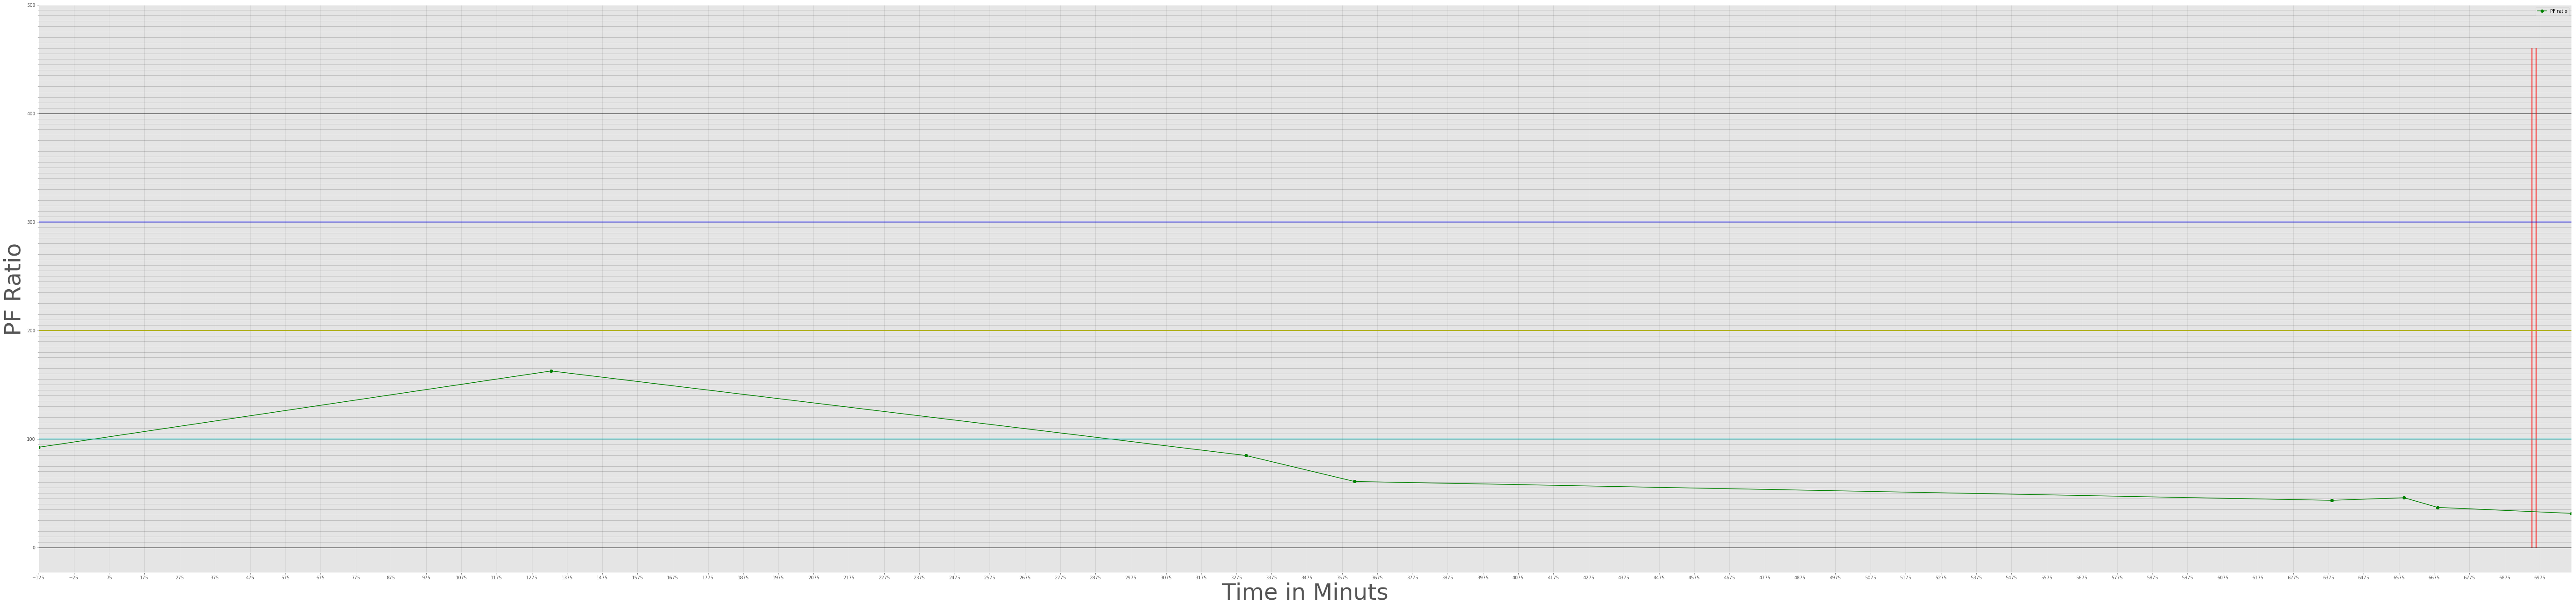

In [135]:
df5 = df3[['PF ratio','lab_time','toffset']].copy()
df6 = df3[['PF ratio', 'toffset']].copy()
%matplotlib inline

min_val = min(min(df5[['toffset','lab_time']].min()),0)
minor_ticks = np.arange(0, 501, 5)
x_major_ticks = np.arange(min_val, df5[['lab_time']].max(), 100)


ax=df5.plot(x=['lab_time'],y='PF ratio', color='g',marker='o', label='PF ratio',figsize=(100,23))
ax.vlines(x=df5['toffset'],ymin=0,ymax=460, color='r', label='prone change')
ax.axhline(y=300, color='b', label='Mild')
ax.axhline(y=200, color='y', label='Moderate')
ax.axhline(y=100, color='c', label='Severe')
ax.set_xlabel('Time in Minuts',fontsize=50)
ax.set_ylabel('PF Ratio', fontsize=50)
ax.set_yticks(minor_ticks,minor=True)
ax.set_xticks(x_major_ticks)
ax.yaxis.grid(True, linestyle='-', which='major', color='black',
               alpha=1)
ax.yaxis.grid(True, linestyle='-', which='minor', color='black',
               alpha=0.2)
ax.xaxis.grid(True, linestyle='-', which='major', color='black',
               alpha=0.1)
# plt.show()
plt.savefig('{}.png'.format(param['phsid']))

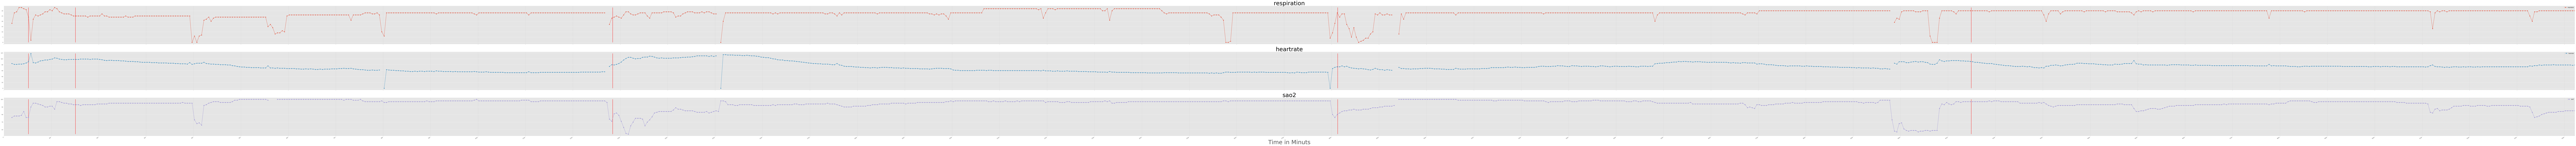

In [96]:
q = """
select 
  vp.observationoffset as obs_offset
  ,respiration
  ,heartrate
  ,sao2
from vitalperiodic vp
where patientunitstayid in (select patientunitstayid from patient
                            where patienthealthsystemstayid = %(phsid)s )
order by obs_offset asc
"""


df_vital = pd.read_sql_query(q, con, params=param)
%matplotlib inline
max_val = df5['lab_time'].max()
df_vital = df_vital[df_vital['obs_offset'] < max_val]
df_vital.reset_index(inplace=True,drop=True)
# fig, axs = plt.subplots(3, 1, sharex=True)
vital_axises = df_vital.plot(subplots=True, figsize=(400, 23), x=['obs_offset'],sort_columns=True, marker='o',sharex=True)

colname = list(df_vital)
vital_axises[0].set_title(colname[1],fontsize=50)
vital_axises[1].set_title(colname[2],fontsize=50)
vital_axises[2].set_title(colname[3],fontsize=50)

# print("max_rr = {}, max_hr = {}, max_sao2 = {}".format(df_vital['respiration'].max()
#                                                        , df_vital['heartrate'].max(), df_vital['sao2'].max()))
y_maxs = [df_vital['respiration'].max(), df_vital['heartrate'].max(), df_vital['sao2'].max()]
y_mins = [df_vital['respiration'].min(), df_vital['heartrate'].min(), df_vital['sao2'].min()]

min_val = min(df_vital['obs_offset'].min(),0)

x_major_ticks = np.arange(min_val, df_vital['obs_offset'].max(), 100)

for idx, v_axis in enumerate(vital_axises):
#     v_axis.set_title()
#     print(df_vital.iloc[idx+1].max())
    y_min = y_mins[idx]
    y_max = y_maxs[idx]
#     df_vital[df_vital.iloc[idx+1] == y_max]
#     v_axis.set_ylim((y_min,y_max))
    v_axis.vlines(x=df5['toffset'],ymin=y_min,ymax=y_max, color='r', label='prone change')
    v_axis.set_xlabel('Time in Minuts',fontsize=50)
    v_axis.set_xticks(x_major_ticks)
    v_axis.xaxis.grid(True, linestyle='-', which='major', color='black',
               alpha=0.1)


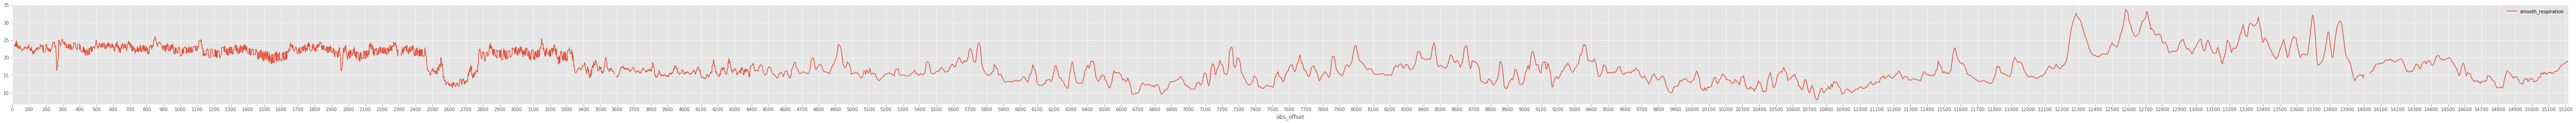

In [71]:
ax = df_vital.plot(x='obs_offset',y='smooth_respiration',figsize=(100,4))
ax.set_xticks(x_major_ticks)

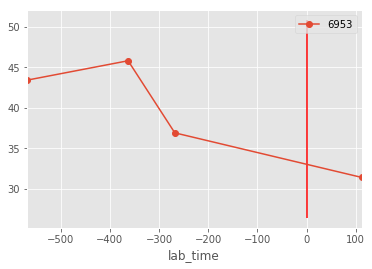

In [136]:
# plt.figure();
# %matplotlib inline

import copy

plt.rcParams['legend.fontsize'] = 10


dict_temp = copy.deepcopy(dict_after)

for d in dict_temp.values():
    d['lab_time'] = d.loc[:,('lab_time')] - d.loc[:,('toffset')]
    d['id'] = d['toffset'].copy()
    d['toffset'] = 0
    d.set_index('id')

dict_temp

dict_temp2 = copy.deepcopy(dict_before)

for d in dict_temp2.values():
    d['lab_time'] = d.loc[:,('lab_time')] - d.loc[:,('toffset')]
    d['id'] = d['toffset'].copy()
    d['toffset'] = 0
    d.set_index('id')



set_keys = set(dict_temp.keys()).union(dict_temp2.keys())

temp_set = pd.DataFrame(list(set_keys),columns=['set'])
temp_set.sort_values(by='set', inplace=True)
temp_set['diff'] = temp_set.diff()
temp_set = temp_set[(temp_set['diff']>2*60) | (temp_set['diff'].isnull())].reset_index(drop=True)

set_keys = set(temp_set.set.values)


temp_dict = {}

fig, ax = plt.subplots()

for key in set_keys:
    temp1 = dict_temp.get(key)
    temp2 = dict_temp2.get(key)
    if temp1 is None:
        temp_dict[key] = temp2.copy()
        continue
    elif temp2 is None:
        temp_dict[key] = temp1.copy()
        continue
    else:
        concated = [temp1, temp2]
        temp_dict[key] = pd.concat(concated, ignore_index=True).copy()
    temp_dict[key].set_index('id')
    temp_dict[key].sort_values('lab_time',inplace=True)
    temp_dict[key].plot(x=['lab_time'],y='PF ratio',marker='o', label=str(key),ax=ax)
    y_min = temp_dict[key]['PF ratio'].min().item()
    y_max = temp_dict[key]['PF ratio'].max().item()
    ax.vlines(x=0,ymin=y_min-5,ymax=y_max+5, color='r', label='prone change')

# plt.legend(loc="upper left", bbox_to_anchor=[0, 1], ncol=3, shadow=True, fancybox=True)

#     d.plot(x=['lab_time'],y='PF ratio', color='g',marker='o', label='PF ratio')

In [98]:
max_time = np.max([df3['lab_time'].max(),df3['toffset'].max()])
min_time = np.min([df3['lab_time'].min(),df3['toffset'].min()])

time_frame = 12*60
print(np.ceil((max_time-min_time + 1)/time_frame))

labels = [ "{0} - {1}".format(i, (i + time_frame)) for i in range(min_time, max_time, time_frame) ]

temp = labels[-1].split(" ")
temp[-1] = str(max_time)
labels[-1] = " ".join(temp)
# df8 = df3[['PF ratio','lab_time','toffset']].drop_duplicates()
df_time_frames = df8.copy()

df_time_frames['strada'] = pd.cut(df_time_frames.toffset, range(min_time, max_time+time_frame, time_frame), right=False, labels=labels)

df_time_frames['x'] = df_time_frames.groupby('strada')['strada'].transform('count')

df_x_patient = pd.DataFrame(data={'strada': labels})



df_temp_x = df_time_frames[['strada','x']].copy()

df_x_patient = df_x_patient.merge(df_temp_x, on='strada',how='left')

df_x_patient['x'] = np.where(df_x_patient['x']>0,1,0)

df_x_patient = df_x_patient.drop_duplicates().reset_index(drop=True)

# df_time_frames
df_x_patient.x.values

9.0


array([1, 1, 0, 1, 0, 1, 0, 0, 1])

In [99]:
# df_time_frames["dif"] = df_time_frames["PF ratio"].diff()

df_pf_diff = df3[["PF ratio", "lab_time"]].copy().drop_duplicates()

In [100]:
df_pf_diff['strada'] = pd.cut(df_pf_diff.lab_time, range(min_time, max_time+time_frame, time_frame), right=False, labels=labels)

tollerence = 0

df_pf_diff.sort_values("lab_time", inplace=True)
df_pf_diff["dif"] = df_pf_diff["PF ratio"].diff()
df_pf_diff.reset_index(inplace=True,drop=True)
# df_pf_diff['result'] = np.sign(df_pf_diff['dif'][np.abs(df_pf_diff['dif']) >= tollerence])
df_pf_diff['result'] = np.sign(df_pf_diff['PF ratio'][df_pf_diff['PF ratio'] > 300])

df_pf_diff.sort_values("strada",inplace=True)
df_pf_diff



,PF ratio,lab_time,strada,dif,result
0,45.000000,134,52 - 772,NaN,NaN
1,72.000000,134,52 - 772,27.000000,NaN
2,135.555556,530,52 - 772,63.555556,NaN
3,162.500000,709,52 - 772,26.944444,NaN
4,146.666667,1210,772 - 1492,-15.833333,NaN
5,45.000000,1322,772 - 1492,-101.666667,NaN
6,85.555556,1976,1492 - 2212,40.555556,NaN
7,103.750000,2114,1492 - 2212,18.194444,NaN
8,97.500000,3641,2932 - 3652,-6.250000,NaN
9,123.750000,3895,3652 - 4372,26.250000,NaN


In [110]:
df_y_patient = pd.DataFrame(data={'strada': labels})


df_temp_y = pd.DataFrame(df_pf_diff['strada'][df_pf_diff["result"]>0].copy().value_counts().reset_index())
df_temp_y.columns = ['strada','y']

df_y_patient = df_y_patient.merge(df_temp_y, on ='strada',how='inner',copy=True)

# df_y_patient.sort_values('strada', inplace=True)
# df_y_patient.reset_index()
# df_temp_y
# df_y_patient.sort_values('strada',inplace=True)
# df_y_patient.reset_index(inplace=True)


# df_y_patient.y.values
mask = df_pf_diff.eval(df_pf_diff["result"]>0)
df_pf_diff['strada'][mask]

Series([], Name: strada, dtype: category
Categories (9, object): [52 - 772 < 772 - 1492 < 1492 - 2212 < 2212 - 2932 ... 3652 - 4372 < 4372 - 5092 < 5092 - 5812 < 5812 - 5831])

In [19]:
# # temp = pd.DataFrame(list(dict_temp2.values()),index=list(dict_temp2.keys())).copy()


# temp = pd.concat(temp_dict, axis=1)
# # temp.columns = temp.columns.droplevel(-1) 

# # temp.plot(x=['lab_time'],y='PF ratio',marker='o', label=str(key))
# ax = temp.plot(x=['lab_time'],y=['PF ratio'],marker='o', label='id',figsize=(30,20))



# # temp_dict[key].sort_values('lab_time',inplace=True)
# # temp_dict[key].plot(x=['lab_time'],y='PF ratio',marker='o', label=str(key),ax=ax)
# y_min = temp_dict[key]['PF ratio'].min().item()
# y_max = temp_dict[key]['PF ratio'].max().item()
# ax.vlines(x=0,ymin=y_min-5,ymax=y_max+5, color='r', label='prone change')
# # dict_temp2

temp_set = pd.DataFrame(list(set_keys),columns=['set'])
temp_set.sort_values(by='set', inplace=True)
temp_set['diff'] = temp_set.diff()
temp_set = temp_set[(temp_set['diff']>2*60) | (temp_set['diff'].isnull())].reset_index(drop=True)

set(temp_set.set.values)

{1322,
 2482,
 2754,
 4019,
 4145,
 5495,
 6922,
 8319,
 8642,
 9778,
 9915,
 11134,
 11411,
 12723,
 14189}

In [111]:

_adverse_ratio = {
    'Normal': (np.float('inf'), 300),
    'Mild': (300, 200),
    'Moderate': (200, 100),
    'Severe': (100, 0)
} 
for key, (max_val, min_val) in _adverse_ratio.items():
    df_pf_diff[key] = ((df_pf_diff['PF ratio'] > min_val) & (df_pf_diff['PF ratio'] <= max_val))
# df_pf_diff['mild'] = ((df_pf_diff['PF ratio'] <= 300) & (df_pf_diff['PF ratio'] > 200))
# df_pf_diff['moderate'] = ((df_pf_diff['PF ratio'] <= 200) & (df_pf_diff['PF ratio'] > 100))
# df_pf_diff['severe'] = ((df_pf_diff['PF ratio'] <= 100) & (df_pf_diff['PF ratio'] >= 0))

# df_pf_diff.drop(['result', 'result2','mild','moderate','severe'],axis=1,inplace=True)

df_pf_diff["temp"] = True

adv_mask = ("df_pf_diff['moderate']")

# df_pf_diff['strada'][eval(adv_mask)].copy().value_counts().reset_index()
df_pf_diff
# df_pf_diff.rename(columns={"result":"mild", "result2":"moderate"},index=str)

,PF ratio,lab_time,strada,dif,result,Normal,Mild,Moderate,Severe,temp
0,45.000000,134,52 - 772,NaN,NaN,False,False,False,True,True
1,72.000000,134,52 - 772,27.000000,NaN,False,False,False,True,True
2,135.555556,530,52 - 772,63.555556,NaN,False,False,True,False,True
3,162.500000,709,52 - 772,26.944444,NaN,False,False,True,False,True
4,146.666667,1210,772 - 1492,-15.833333,NaN,False,False,True,False,True
5,45.000000,1322,772 - 1492,-101.666667,NaN,False,False,False,True,True
6,85.555556,1976,1492 - 2212,40.555556,NaN,False,False,False,True,True
7,103.750000,2114,1492 - 2212,18.194444,NaN,False,False,True,False,True
8,97.500000,3641,2932 - 3652,-6.250000,NaN,False,False,False,True,True
9,123.750000,3895,3652 - 4372,26.250000,NaN,False,False,True,False,True


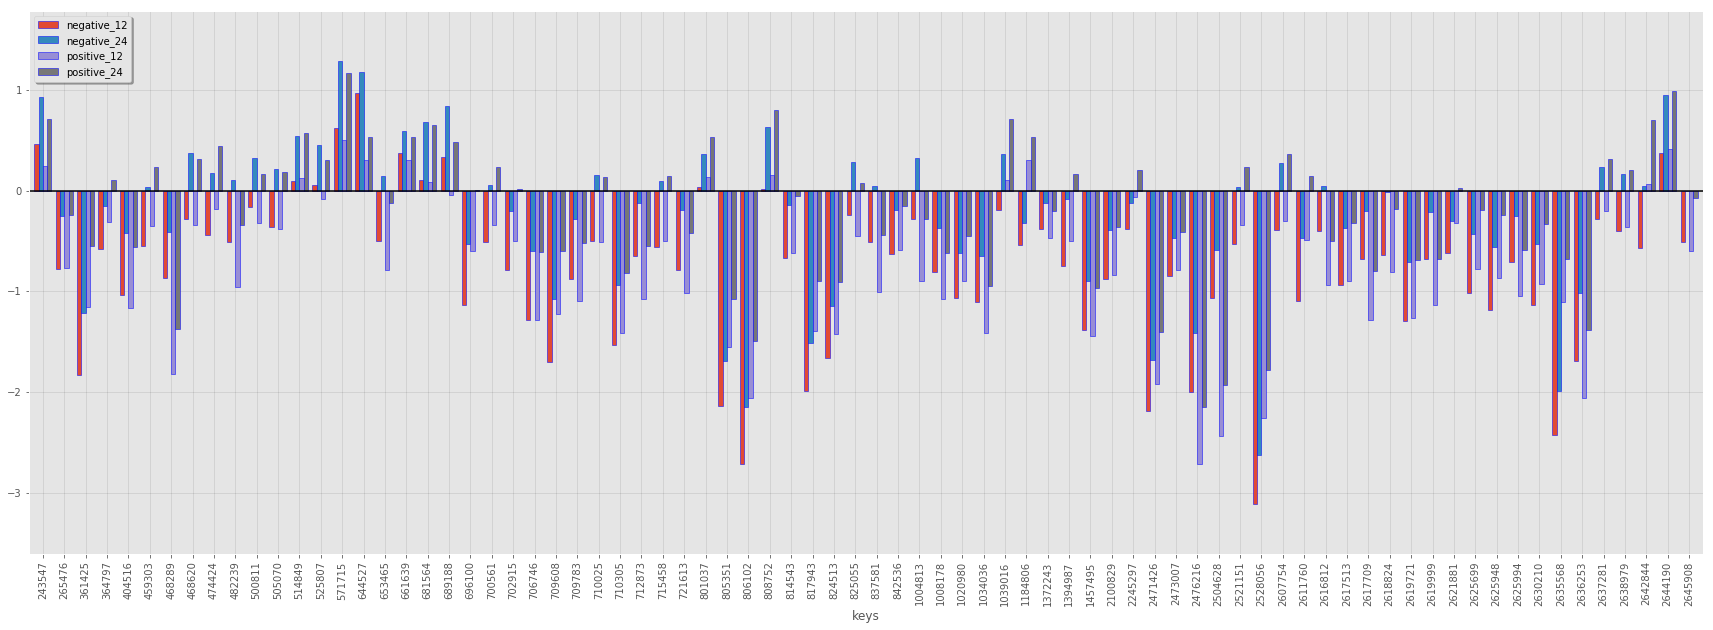

In [112]:
import pickle

base = 'C:\\Users\\RomG\\PycharmProjects\\eICU_ARDS\\'
res_pos_12 = pickle.load(open(base + 'optimize_res_positive_12.0.pkl','rb'))
plt.rcParams['legend.fontsize'] = 10

vec = res_pos_12.x

phi_vec_pos_12 = vec[:-1]
beta_pos_12 = vec[-1:].item()


res_neg_12 = pickle.load(open(base + 'optimize_res_negative_12.0.pkl','rb'))

vec_neg = res_neg_12.x
phi_vec_neg_12 = vec_neg[:-1]
beta_neg_12 = vec_neg[-1:].item()

res_pos_24 = pickle.load(open(base + 'optimize_res_positive_24.0.pkl','rb'))

vec_pos_24 = res_pos_24.x
phi_vec_pos_24 = vec_pos_24[:-1]
beta_pos_24 = vec_pos_24[-1:].item()

res_neg_24 = pickle.load(open(base + 'optimize_res_negative_24.0.pkl','rb'))

vec_neg_24 = res_neg_24.x
phi_vec_neg_24 = vec_neg_24[:-1]
beta_neg_24 = vec_neg_24[-1:].item()

patients_ids = pickle.load(open(base + 'keys.pkl','rb'))

phi_vecs = pd.DataFrame({"keys": patients_ids,
                         "positive_12": phi_vec_pos_12, "negative_12": phi_vec_neg_12,
                         "positive_24": phi_vec_pos_24, "negative_24": phi_vec_neg_24})

phi_vecs.set_index("keys", inplace=True)

ax = phi_vecs.plot(kind="bar",fontsize=10,figsize=(30,10),width=0.8 ,ylim=(min(phi_vecs.min())-0.5, max(phi_vecs.max())+0.5),edgecolor = ['b']*phi_vecs.shape[0])
plt.axhline(0, color='k')

plt.legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=1, shadow=True, fancybox=True)
ax.xaxis.grid(True, linestyle='-', which='major', color='black',
               alpha=0.1)

ax.yaxis.grid(True, linestyle='-', which='major', color='black',
               alpha=0.1)



# print(phi_vecs.shape[0])



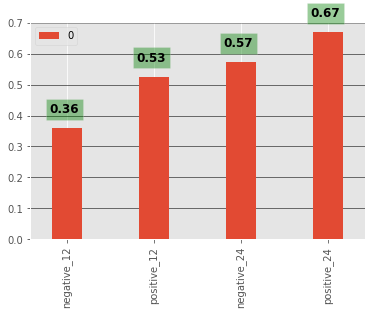

In [113]:
beta_vecs = pd.DataFrame({"positive_12": beta_pos_12, "negative_12": beta_neg_12,
                         "positive_24": beta_pos_24, "negative_24": beta_neg_24},index=[0])
beta_vecs = beta_vecs.transpose()

beta_vecs = beta_vecs.reindex(index=beta_vecs.index.to_series().str.rsplit('_').str[-1].astype(int).sort_values().index)


ax = beta_vecs.plot(kind="bar",width=0.35,fontsize=10,grid=True)

minor_ticks = np.arange(0, max(beta_vecs.max()), 0.1)

ax.set_yticks(minor_ticks,minor=True)

ax.yaxis.grid(True, linestyle='-', which='both', color='black',
               alpha=0.4)
count=0
for i, v in beta_vecs.iterrows():
    ax.text(count-0.2,v.item()+0.05, "{:.2f}".format(v.item()), color='black', fontweight='bold', fontsize=12,bbox=dict(facecolor='green', alpha=0.4))
    count+=1

In [108]:
beta_vecs['rate'] = np.exp(beta_vecs[0])

beta_vecs

,0,rate
negative_12,0.359284,1.432304
positive_12,0.525886,1.691958
negative_24,0.571863,1.771565
positive_24,0.669264,1.952801


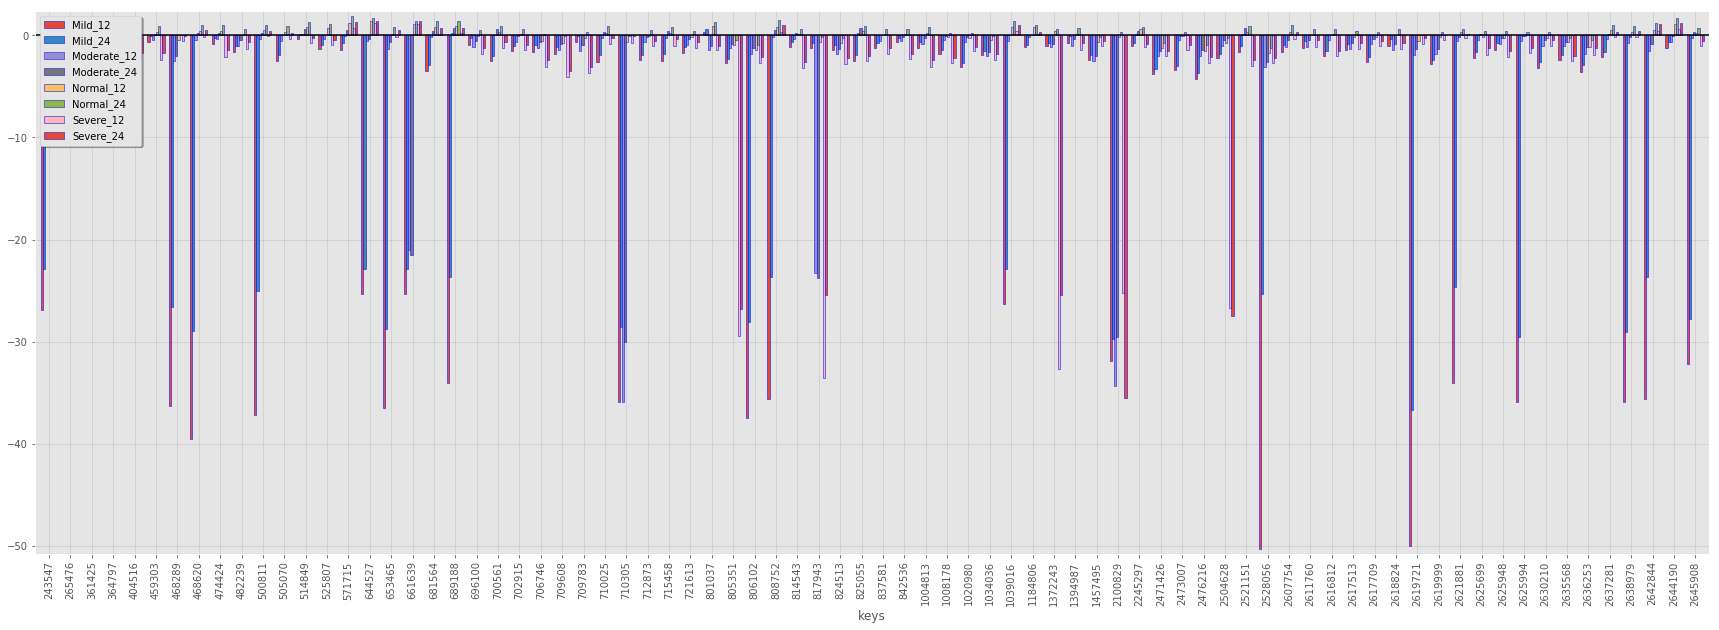

In [23]:
res_mild_12 = pickle.load(open(base + 'optimize_res_Mild_12.0.pkl','rb'))
plt.rcParams['legend.fontsize'] = 10

vec_mild_12 = res_mild_12.x

phi_vec_mild_12 = vec_mild_12[:-1]
beta_mild_12 = vec_mild_12[-1:].item()


res_moderate_12 = pickle.load(open(base + 'optimize_res_Moderate_12.0.pkl','rb'))

vec_moderate_12 = res_moderate_12.x
phi_vec_moderate_12 = vec_moderate_12[:-1]
beta_moderate_12 = vec_moderate_12[-1:].item()

res_normal_12 = pickle.load(open(base + 'optimize_res_Normal_12.0.pkl','rb'))

vec_normal_12 = res_normal_12.x
phi_vec_normal_12 = vec_normal_12[:-1]
beta_normal_12 = vec_normal_12[-1:].item()

res_severe_12 = pickle.load(open(base + 'optimize_res_Severe_12.0.pkl','rb'))

vec_severe_12 = res_severe_12.x
phi_vec_severe_12 = vec_severe_12[:-1]
beta_severe_12 = vec_severe_12[-1:].item()


res_mild_24 = pickle.load(open(base + 'optimize_res_Mild_24.0.pkl','rb'))

vec_mild_24 = res_mild_24.x
phi_vec_mild_24 = vec_mild_24[:-1]
beta_mild_24 = vec_mild_24[-1:].item()


res_moderate_24 = pickle.load(open(base + 'optimize_res_Moderate_24.0.pkl','rb'))

vec_moderate_24 = res_moderate_24.x
phi_vec_moderate_24 = vec_moderate_24[:-1]
beta_moderate_24 = vec_moderate_24[-1:].item()

res_normal_24 = pickle.load(open(base + 'optimize_res_Normal_24.0.pkl','rb'))

vec_normal_24 = res_normal_24.x
phi_vec_normal_24 = vec_normal_24[:-1]
beta_normal_24 = vec_normal_24[-1:].item()

res_severe_24 = pickle.load(open(base + 'optimize_res_Severe_24.0.pkl','rb'))

vec_severe_24 = res_severe_24.x
phi_vec_severe_24 = vec_severe_24[:-1]
beta_severe_24 = vec_severe_24[-1:].item()


phi_vecs_abs = pd.DataFrame({"keys": patients_ids,
                         "Normal_12": phi_vec_normal_12, "Mild_12": phi_vec_mild_12,
                         "Moderate_12": phi_vec_moderate_12, "Severe_12": phi_vec_severe_12,
                         "Normal_24": phi_vec_normal_24, "Mild_24": phi_vec_mild_24,
                         "Moderate_24": phi_vec_moderate_24, "Severe_24": phi_vec_severe_24})

phi_vecs_abs.set_index("keys", inplace=True)

ax = phi_vecs_abs.plot(kind="bar",fontsize=10,figsize=(30,10)
                       ,width=0.8 ,ylim=(min(phi_vecs_abs.min())-0.5, max(phi_vecs_abs.max())+0.5)
                       ,edgecolor = ['b']*phi_vecs_abs.shape[0])
plt.axhline(0, color='k')

plt.legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=1, shadow=True, fancybox=True)
ax.xaxis.grid(True, linestyle='-', which='major', color='black',
               alpha=0.1)

ax.yaxis.grid(True, linestyle='-', which='major', color='black',
               alpha=0.1)

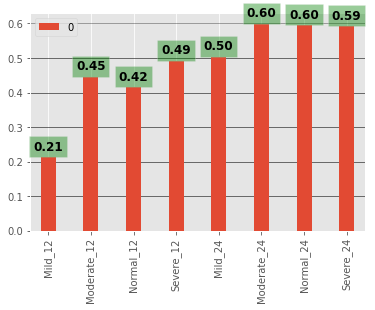

In [81]:
beta_vecs_abs = pd.DataFrame({"Normal_12": beta_normal_12, "Mild_12": beta_mild_12,
                              "Moderate_12": beta_moderate_12, "Severe_12": beta_severe_12,
                              "Normal_24": beta_normal_24, "Mild_24": beta_mild_24,
                              "Moderate_24": beta_moderate_24, "Severe_24": beta_severe_24},index=[0])
beta_vecs_abs = beta_vecs_abs.transpose()
beta_vecs_abs = beta_vecs_abs.reindex(index=beta_vecs_abs.index.to_series().str.rsplit('_').str[-1].astype(int).sort_values().index)


ax = beta_vecs_abs.plot(kind="bar",width=0.35,fontsize=10,grid=True)

minor_ticks = np.arange(0, max(beta_vecs_abs.max()), 0.1)

ax.set_yticks(minor_ticks,minor=True)

ax.yaxis.grid(True, linestyle='-', which='both', color='black',
               alpha=0.4)
count=0
for i, v in beta_vecs_abs.iterrows():
    ax.text(count-0.35,v.item()+0.02, "{:.2f}".format(v.item()), color='black', fontweight='bold', fontsize=12,bbox=dict(facecolor='green', alpha=0.4))
    count+=1

In [107]:

beta_vecs_abs['rate'] = np.exp(beta_vecs_abs[0])

beta_vecs_abs

,0,rate
Mild_12,0.212762,1.237090
Moderate_12,0.445499,1.561270
Normal_12,0.415098,1.514519
Severe_12,0.491655,1.635020
Mild_24,0.503670,1.654782
Moderate_24,0.599612,1.821412
Normal_24,0.595706,1.814311
Severe_24,0.592090,1.807763
